In [93]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import sklearn as sk
import seaborn as sns

In [5]:
style.use('ggplot')

start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()

In [15]:
ticker_df = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')

In [51]:
# tickers = ticker_df['Symbol'].values.tolist()
tickers = ['SPY', 'QQQ', 'ARKK', 'TLT', 'VNQ', 'VNQI']

In [513]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime.now()
no_data = ['CTL', 'COP','CXO', 'ETFC']
for ticker in tickers:
    # just in case your connection breaks, we'd like to save our progress!
    if not os.path.exists('data/{}.csv'.format(ticker)) and '.' not in ticker and ticker not in no_data:
        df = web.DataReader(ticker, 'yahoo', start, end)
        df.reset_index(inplace=True)
        df.set_index("Date", inplace=True)
        df.to_csv('data/{}.csv'.format(ticker))
    else:
        print('Already have {}'.format(ticker))

Already have SPY
Already have QQQ
Already have ARKK
Already have TLT
Already have VNQ
Already have VNQI


In [49]:
df = pd.read_csv('data/SPY.csv', index_col=0, parse_dates=True)
df.columns = df.columns.str.lower()
df['year'] = df.index.year
df['month'] = df.index.month
df
  

,high,low,open,close,volume,adj close,year,month
Date,,,,,,,,
2009-12-31,112.800003,111.389999,112.769997,111.440002,90637900.0,89.568359,2009,12
2010-01-04,113.389999,111.510002,112.370003,113.330002,118944600.0,91.087418,2010,1
2010-01-05,113.680000,112.849998,113.260002,113.629997,111579900.0,91.328552,2010,1
2010-01-06,113.989998,113.430000,113.519997,113.709999,116074400.0,91.392838,2010,1
2010-01-07,114.330002,113.180000,113.500000,114.190002,131091100.0,91.778671,2010,1
...,...,...,...,...,...,...,...,...
2021-02-12,392.899994,389.769989,389.850006,392.640015,50505700.0,392.640015,2021,2
2021-02-16,394.170013,391.529999,393.959991,392.299988,50700800.0,392.299988,2021,2
2021-02-17,392.660004,389.329987,390.420013,392.390015,52290600.0,392.390015,2021,2


In [50]:
month_start_df = df.resample('BMS').first()
month_end_df = df.resample('BM').last()
month_start_df.drop(['open', 'close','volume', 'low', 'high'], axis=1, inplace=True)
month_end_df.drop(['open', 'close','volume', 'low', 'high'], axis=1, inplace=True)

In [51]:
combine = pd.merge(month_start_df, month_end_df, how='inner', on=['year','month'], suffixes=('_start','_end'))
combine['monthly diff'] = combine['adj close_end'] - combine['adj close_start']
# 1 = positive movement -> rise 0 = negative movement -> drop 
combine['change'] = combine['monthly diff'].apply(lambda x: 1 if x > 0 else 0)

# total 6 months to be include in the prediction
month_incl = 12
for i in range(month_incl):
    combine['delta_{}'.format(i+1)] = combine['change'].shift(i+1)
    # combine['change_{}'.format(i+1)] = combine['change_{}'.format(i+1)].round(-1) 
# combine['change_1'] = combine['change'].shift(1)
# combine['change_2'] = combine['change'].shift(2)
# drop the last row
combine.drop(combine.tail(1).index, inplace=True)

# extract the row of features that we will use for prediction
feature_df = combine.tail(1)
combine

,adj close_start,year,month,adj close_end,monthly diff,change,delta_1,delta_2,delta_3,delta_4,delta_5,delta_6,delta_7,delta_8,delta_9,delta_10,delta_11,delta_12
0,89.568359,2009,12,89.568359,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,91.087418,2010,1,86.313232,-4.774185,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,87.655464,2010,2,89.005737,1.350273,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89.930054,2010,3,94.424400,4.494347,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,95.070015,2010,4,95.885147,0.815132,1,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,349.703522,2020,9,333.468567,-16.234955,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
130,335.609406,2020,10,325.153992,-10.455414,0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
131,328.798462,2020,11,360.523224,31.724762,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
132,364.466400,2020,12,373.880005,9.413605,1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [52]:
# count how many rise and how many drop
combine['change'].value_counts()

1    91
0    43
Name: change, dtype: int64

In [53]:
91/(43+91)

0.6791044776119403

In [66]:
# check the distribution
combine.groupby(['month','change']).size()

month  change
1      0         5
       1         7
2      0         3
       1         8
3      0         4
       1         7
4      0         2
       1         9
5      0         4
       1         7
6      0         5
       1         6
7      0         2
       1         9
8      0         5
       1         6
9      0         3
       1         8
10     0         4
       1         7
11     0         3
       1         8
12     0         3
       1         9
dtype: int64

In [12]:
combine.dropna(inplace=True)
combine.drop(['adj close_start',
 'year',
 #'month',
 'adj close_end',
 'monthly diff'], axis = 1, inplace=True)


In [13]:
feature_cols = [col for col in combine.columns if 'change' not in col]
feature_cols

['month',
 'delta_1',
 'delta_2',
 'delta_3',
 'delta_4',
 'delta_5',
 'delta_6',
 'delta_7',
 'delta_8',
 'delta_9',
 'delta_10',
 'delta_11',
 'delta_12']

In [14]:
# combine[feature_cols] = combine[feature_cols].astype('category')
# pd.get_dummies(combine[feature_cols])

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,delta_8_0.0,delta_8_1.0,delta_9_0.0,delta_9_1.0,delta_10_0.0,delta_10_1.0,delta_11_0.0,delta_11_1.0,delta_12_0.0,delta_12_1.0
12,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
13,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
14,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,1
15,0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
16,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,1,0,1,0,1
130,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,1,0,1,0,1
131,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,1,0,1
132,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1


In [31]:
X = combine[feature_cols].values
y = combine['change'].values

In [32]:
X
y

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics


In [18]:

'''
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(X,y)

for train_index, test_index in sss.split(X,y):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

'''
X_train, X_valid, y_train, y_valid = train_test_split(X,y, stratify=y, test_size=0.2)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(97, 13) (25, 13) (97,) (25,)


In [19]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

0.64

In [20]:
# pred_change = lgm.predict(X_valid)

# compare = pd.DataFrame({'Actual': y_valid, 'Predict': pred_change})#.set_index('Actual')
# pred_df = pd.DataFrame({'Predict':pred_change})
# pd.merge(combine, pred_df, left_index=True, right_index=True)

for X,y in list(zip(X_valid, y_valid)):
    pred = clf.predict([X])[0]
    print('Predict {}'.format(pred), 'Actual {}'.format(y))
    '''
    if pred == 1 and y == 1:
        print('Match 0')
    elif pred == 0 and y == 0:
        print('Match 0')
    elif pred == 1 and y == 0:
        print('Unmatch Drop')
    else:
        print('Unmatch Rise')
    '''


Predict 1 Actual 1
Predict 0 Actual 1
Predict 0 Actual 0
Predict 1 Actual 1
Predict 1 Actual 0
Predict 1 Actual 1
Predict 1 Actual 0
Predict 1 Actual 0
Predict 1 Actual 0
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 0
Predict 1 Actual 1
Predict 1 Actual 1
Predict 0 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 0 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 0 Actual 0
Predict 1 Actual 1
Predict 1 Actual 0


Text(15.0, 0.5, 'Actual')

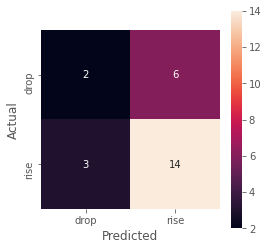

In [21]:
y_pred = clf.predict(X_valid)

cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)



fig, ax = plt.subplots(1,1, figsize=(4,4))
ax = sns.heatmap(cnf_matrix, annot=True, square=True,
xticklabels = ['drop', 'rise'],
yticklabels = ['drop', 'rise']
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# np.set_printoptions(precision=2)



# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=[1,0])

In [22]:
from sklearn import svm

clf = svm.SVC(kernel='rbf', C=0.025).fit(X_train, y_train)
clf.score(X_valid, y_valid)


0.68

In [23]:

'''
pred_change = clf.predict(X_valid)

pred_df = pd.DataFrame({'Predict':pred_change})
pd.merge(combine, pred_df, left_index=True, right_index=True)
'''

for X,y in list(zip(X_valid, y_valid)):
    pred = clf.predict([X])[0]
    print('Predict {}'.format(pred), 'Actual {}'.format(y))
    '''
    if pred == 1 and y == 1:
        print('Match 0')
    elif pred == 0 and y == 0:
        print('Match 0')
    elif pred == 1 and y == 0:
        print('Unmatch Drop')
    else:
        print('Unmatch Rise')
    '''

Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 0
Predict 1 Actual 1
Predict 1 Actual 0
Predict 1 Actual 1
Predict 1 Actual 0
Predict 1 Actual 0
Predict 1 Actual 0
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 0
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 1
Predict 1 Actual 0
Predict 1 Actual 1
Predict 1 Actual 0


'\nnp.set_printoptions(precision=2)\nplt.figure()\nplot_confusion_matrix(cnf_matrix, classes=[1,0])\n'

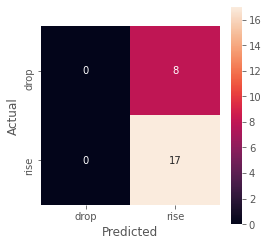

In [24]:
y_pred = clf.predict(X_valid)

cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)


fig, ax = plt.subplots(1,1, figsize=(4,4))
ax = sns.heatmap(cnf_matrix, annot=True, square=True,
xticklabels = ['drop', 'rise'],
yticklabels = ['drop', 'rise']
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
'''
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,0])
'''

In [25]:
clf = svm.SVC(gamma=2, C=1).fit(X_train, y_train)

clf.score(X_valid, y_valid)

0.68

'\nnp.set_printoptions(precision=2)\nplt.figure()\nplot_confusion_matrix(cnf_matrix, classes=[1,0])\n'

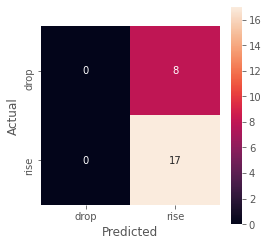

In [26]:
y_pred = clf.predict(X_valid)

cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)


fig, ax = plt.subplots(1,1, figsize=(4,4))
ax = sns.heatmap(cnf_matrix, annot=True, square=True,
xticklabels = ['drop', 'rise'],
yticklabels = ['drop', 'rise']
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

'''
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,0])
'''

In [27]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(3).fit(X_train, y_train)
clf.score(X_valid, y_valid)



0.48

Text(15.0, 0.5, 'Actual')

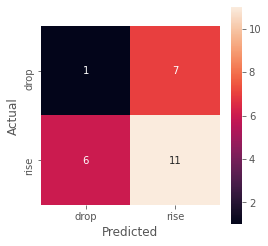

In [28]:
y_pred = clf.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax = sns.heatmap(cnf_matrix, annot=True, square=True,
xticklabels = ['drop', 'rise'],
yticklabels = ['drop', 'rise']
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')


In [33]:
import sklearn.model_selection as skms
param_grid = {"n_neighbors" : [1,3,5,10,20,30,40]}

knn = KNeighborsClassifier()
# warning! this is with accuracy
grid_model = skms.GridSearchCV(knn,
                               return_train_score=True,
                               param_grid = param_grid, 
                               cv=10)
grid_model.fit(X,y)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10, 20, 30, 40]},
             return_train_score=True)

In [34]:
param_cols = ['param_n_neighbors']
score_cols = ['mean_train_score', 'std_train_score',
              'mean_test_score', 'std_test_score']

# look at first five params with head()
df = pd.DataFrame(grid_model.cv_results_)#.head(5)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.000926,0.001192,0.001567,0.001246,1,{'n_neighbors': 1},0.769231,0.384615,0.583333,0.583333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.000516,0.000140,0.001022,0.000068,3,{'n_neighbors': 3},0.538462,0.384615,0.666667,0.666667,...,0.754545,0.763636,0.800000,0.781818,0.772727,0.763636,0.772727,0.754545,0.770492,0.012695
2,0.000462,0.000104,0.001046,0.000162,5,{'n_neighbors': 5},0.615385,0.538462,0.666667,0.583333,...,0.709091,0.736364,0.709091,0.772727,0.754545,0.709091,0.772727,0.681818,0.731334,0.028476
3,0.000537,0.000152,0.001084,0.000102,10,{'n_neighbors': 10},0.692308,0.615385,0.666667,0.583333,...,0.672727,0.727273,0.672727,0.745455,0.709091,0.718182,0.700000,0.718182,0.703978,0.022732
4,0.000450,0.000094,0.001000,0.000043,20,{'n_neighbors': 20},0.692308,0.692308,0.750000,0.750000,...,0.690909,0.690909,0.681818,0.718182,0.718182,0.709091,0.700000,0.700000,0.698524,0.012257
5,0.000460,0.000072,0.001161,0.000354,30,{'n_neighbors': 30},0.692308,0.692308,0.750000,0.750000,...,0.690909,0.690909,0.690909,0.700000,0.700000,0.700000,0.700000,0.700000,0.696722,0.003945
6,0.000473,0.000127,0.001023,0.000070,40,{'n_neighbors': 40},0.692308,0.692308,0.750000,0.750000,...,0.690909,0.690909,0.690909,0.700000,0.700000,0.700000,0.700000,0.700000,0.696722,0.003945


In [35]:
# subselect columns of interest:  
# param_* is a bit verbose
grid_df = pd.DataFrame(grid_model.cv_results_, 
                       columns=['param_n_neighbors',
                                'mean_train_score',
                                'mean_test_score'])
grid_df.set_index('param_n_neighbors', inplace=True)
grid_df

,mean_train_score,mean_test_score
param_n_neighbors,,
1,1.000000,0.523718
3,0.770492,0.575641
5,0.731334,0.598718
10,0.703978,0.614103
20,0.698524,0.680128
30,0.696722,0.696795
40,0.696722,0.696795


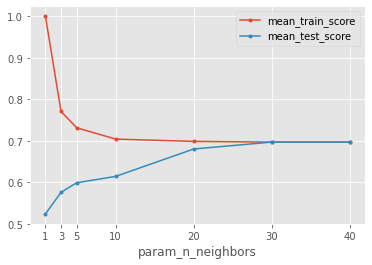

In [36]:
ax = grid_df.plot.line(marker='.')
ax.set_xticks(grid_df.index);

In [37]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)

clf.score(X_valid, y_valid)



0.68

Text(15.0, 0.5, 'Actual')

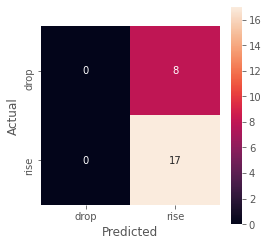

In [38]:
y_pred = clf.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix


fig, ax = plt.subplots(1,1, figsize=(4,4))
ax = sns.heatmap(cnf_matrix, annot=True, square=True,
xticklabels = ['drop', 'rise'],
yticklabels = ['drop', 'rise']
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [39]:
# Grid search
param_grid = {"max_depth" : [1,3,5,7,10,11,20]}

# knn = neighbors.KNeighborsClassifier()
dtree = DecisionTreeClassifier()
# warning! this is with accuracy
grid_model = skms.GridSearchCV(dtree,
                               return_train_score=True,
                               param_grid = param_grid, 
                               cv=10)

grid_model.fit(X, y)



GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 10, 11, 20]},
             return_train_score=True)

In [40]:
param_cols = ['param_max_depth']
score_cols = ['mean_train_score', 'std_train_score',
              'mean_test_score', 'std_test_score']

# look at first five params with head()
df = pd.DataFrame(grid_model.cv_results_)#.head(5)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.001190,0.001646,0.000465,0.000326,1,{'max_depth': 1},0.692308,0.692308,0.750000,0.750000,...,0.690909,0.690909,0.690909,0.700000,0.700000,0.700000,0.700000,0.700000,0.696722,0.003945
1,0.000397,0.000065,0.000227,0.000020,3,{'max_depth': 3},0.615385,0.538462,0.666667,0.583333,...,0.745455,0.736364,0.754545,0.763636,0.736364,0.727273,0.709091,0.745455,0.741359,0.014546
2,0.000476,0.000130,0.000237,0.000042,5,{'max_depth': 5},0.692308,0.307692,0.750000,0.583333,...,0.854545,0.845455,0.854545,0.863636,0.854545,0.845455,0.827273,0.836364,0.850659,0.011376
3,0.000437,0.000029,0.000229,0.000026,7,{'max_depth': 7},0.461538,0.230769,0.666667,0.583333,...,0.954545,0.945455,0.972727,0.936364,0.972727,0.927273,0.900000,0.954545,0.947189,0.021026
4,0.000513,0.000096,0.000261,0.000085,10,{'max_depth': 10},0.461538,0.230769,0.750000,0.500000,...,1.000000,1.000000,1.000000,0.972727,1.000000,1.000000,0.972727,1.000000,0.993628,0.010797
5,0.000493,0.000115,0.000255,0.000078,11,{'max_depth': 11},0.461538,0.230769,0.666667,0.666667,...,1.000000,1.000000,1.000000,0.972727,1.000000,1.000000,1.000000,1.000000,0.996355,0.008337
6,0.000444,0.000058,0.000227,0.000022,20,{'max_depth': 20},0.538462,0.230769,0.666667,0.666667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [41]:
# subselect columns of interest:  
# param_* is a bit verbose
grid_df = pd.DataFrame(grid_model.cv_results_, 
                       columns=['param_max_depth',
                                'mean_train_score',
                                'mean_test_score'])
grid_df.set_index('param_max_depth', inplace=True)
grid_df

,mean_train_score,mean_test_score
param_max_depth,,
1,0.696722,0.696795
3,0.741359,0.573718
5,0.850659,0.508333
7,0.947189,0.485897
10,0.993628,0.502564
11,0.996355,0.494231
20,1.000000,0.510256


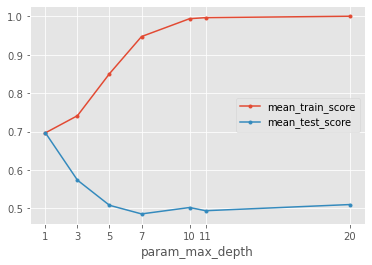

In [42]:
ax = grid_df.plot.line(marker='.')
ax.set_xticks(grid_df.index);

In [43]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
clf.score(X_valid,y_valid)

0.44

Text(15.0, 0.5, 'Actual')

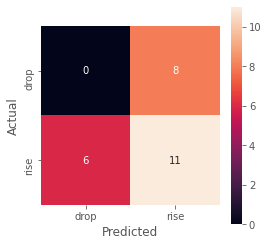

In [45]:
y_pred = clf.predict(X_valid)

cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax = sns.heatmap(cnf_matrix, annot=True, square=True,
xticklabels = ['drop', 'rise'],
yticklabels = ['drop', 'rise']
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [602]:
import itertools
from sklearn import metrics

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
            horizontalalignment="center",
            color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')






In [71]:
# Multiple Classifier all at once

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score

models = {'LogisticRegression': LogisticRegression(), 'SVC': SVC(), 'KNeighbors': KNeighborsClassifier(3), 'RandomForest': RandomForestClassifier(), 'RF2': RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10, random_state=0, max_features=None)}

results = []
for name, model in models.items():
    result = cross_val_score(model, X, y, cv=5)
    results.append([name, result.mean()])

result_df = pd.DataFrame(results, columns=['Name', 'Score'])    
result_df


,Name,Score
0,LogisticRegression,0.672667
1,SVC,0.697000
2,KNeighbors,0.557667
3,RandomForest,0.639333
4,RF2,0.631667


In [84]:
def prep_data(symbol, months, month_drop='no'):
    df = pd.read_csv('data/{}.csv'.format(symbol), index_col=0, parse_dates=True)
    df.columns = df.columns.str.lower()
    df['year'] = df.index.year
    df['month'] = df.index.month

    # select month start and month end data
    month_start_df = df.resample('BMS').first()
    month_end_df = df.resample('BM').last()
    
    # keep on the adj close only
    month_start_df.drop(['open', 'close','volume', 'low', 'high'], axis=1, inplace=True)
    month_end_df.drop(['open', 'close','volume', 'low', 'high'], axis=1, inplace=True)

    combine = pd.merge(month_start_df, month_end_df, how='inner', on=['year','month'], suffixes=('_start','_end'))

    combine['monthly diff'] = combine['adj close_end'] - combine['adj close_start']
    # 1 = positive movement -> rise 0 = negative movement -> drop 
    combine['change'] = combine['monthly diff'].apply(lambda x: 1 if x > 0 else 0)

    # total 6 months to be include in the prediction
    month_incl = months
    for i in range(month_incl):
        combine['delta_{}'.format(i+1)] = combine['change'].shift(i+1)

    # drop the last row
    combine.drop(combine.tail(1).index, inplace=True)

    combine.dropna(inplace=True)
    if month_drop is 'no':
        combine.drop(['adj close_start',
        'year',
        #'month',
        'adj close_end',
        'monthly diff'], axis = 1, inplace=True)
    else:
        combine.drop(['adj close_start',
        'year',
        'month',
        'adj close_end',
        'monthly diff'], axis = 1, inplace=True)
    return combine

In [149]:

# try to evaluate feeding in different months of data and evaluate the results
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score

models = {'LogisticRegression': LogisticRegression(), 'SVC': SVC(), 'SVC2': SVC(kernel='rbf', C=0.025), 'KNeighbors': KNeighborsClassifier(3), 'RandomForest': RandomForestClassifier(), 'RF2': RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10, random_state=0, max_features=None), 'DecisionTree': DecisionTreeClassifier(), 'GaussianNB': GaussianNB()}

results = []

for i in range(12):
    df = prep_data('QQQ', i)
    feature_cols = [x for x  in df.columns if x not in 'change']
    X = df[feature_cols].values
    y = df['change'].values

    for name, model in models.items():
        result = cross_val_score(model, X, y, cv=5)
        results.append([name, result.mean(), i])

result_df = pd.DataFrame(results, columns=['Name', 'Score', 'Month'])    
result_df




,Name,Score,Month
0,LogisticRegression,0.626781,0
1,SVC,0.626781,0
2,SVC2,0.626781,0
3,KNeighbors,0.470940,0
4,RandomForest,0.536467,0
...,...,...,...
91,KNeighbors,0.456667,11
92,RandomForest,0.512000,11
93,RF2,0.455333,11
94,DecisionTree,0.496333,11


In [150]:
resdf = result_df.pivot_table(columns='Month',index='Name', values='Score').reset_index()


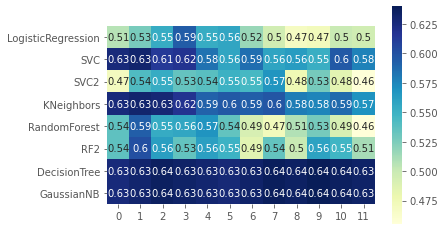

In [155]:
result_matrix = resdf.drop('Name', axis=1).values

models_label = ['LogisticRegression', 'SVC', 'SVC2', 'KNeighbors', 'RandomForest', 'RF2', 'DecisionTree', 'GaussianNB']
ax = sns.heatmap(result_matrix, annot=True, square=True, yticklabels = models_label, cmap='YlGnBu')

<AxesSubplot:xlabel='Month', ylabel='Score'>

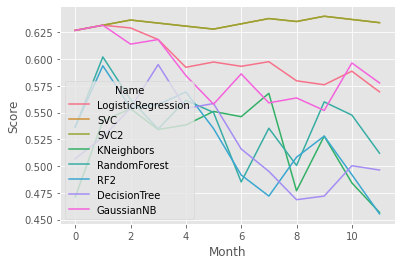

In [154]:
sns.lineplot(data=result_df, x="Month", y='Score', hue='Name')

0     0.626781
1     0.626781
2     0.470940
3     0.573789
4     0.536752
        ...   
79    0.456667
80    0.496000
81    0.455333
82    0.448000
83    0.577667
Name: Score, Length: 84, dtype: float64